# CS 109A/AC 209A/STAT 121A Data Science: Midterm #1 (Coding Solutions)
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>

It is Oct 13, 2016. NASA’s radars discovered a small, 3 meter iron base meteorite, that just entered the Earth’s atmosphere. A small meteorite will not create a big devastation but still dangerous for the citizens. Local authorities would like to know the location of the impact point so they can warn people and allocate resources based on the population that is affected.
The Governor has sought out the best data scientist in the state, you, to help save the day!

You are given two datasets:
- Radar position estimates (x,y,z; z being the altitude) of the meteorite at various times are released on a web page (URL [here](https://cs109alabs.github.io/lab_files/)). x,y and z are coordinates in kilometers and time is in seconds.
- Locations and other details of every dwelling in the town can be found in the file midtermbuildings.csv.


1. Using methods you learned in class estimate the expected point of impact along with the region with 90% certainty.
2. Using the dwelling database, estimate the total number of people that will most likely be affected within this region.

AC209a students only: Additional measurements from another radar are released in the file midterm_a_r2_d1.csv. The accuracy of this radar is approximately 5 times higher than the first radar. Your model should take into account radar data sets.

**Disclaimer (Please Read)**: 

Like in all solutions, we try to err on the side of being overly explicit. We do not expect this level of exposition in your midterm solutions. Similarly, there are many places where we could have made our code far more succinct, but we've chosen not to do so in order to maximize readability - the code you submit for the midterm will likely be much more condensed.

We have also tried to be honest about all the choices we make in the data collection, modeling, prediction, analysis process. We have tried to point out other (perhaps more) valid choices one could have made at each juncture. **Depending on the choices you made in your midterm solution, your predicted impact region and number of residents affected may be different**. However, we expect all reasonable approaches to this problem to generate results in the same (albeit large) ball-park.

In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression as Linear
from bs4 import BeautifulSoup
import urllib
import sys

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.patches as patches
import requests 
%matplotlib inline

## Predicting Impact Point

### Step 1: Read and parse the html file containing the first set of radar readings.

In this part we use the solution to the Challenge problem in Homework #0.

In [25]:
#From Homework #0: 

#Open page and parse html
page = requests.get('https://cs109alabs.github.io/lab_files/', timeout=20,verify=False).text
soup = BeautifulSoup(page, "html5lib")

print(soup.prettify()[:1000])

/usr/local/lib/python3.6/site-packages/requests/packages/urllib3/connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


<html>
 <head>
  <title>
   Save the World!
  </title>
  <style type="text/css">
   .tg  {border-collapse:collapse;border-spacing:0;width:785px}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top}
.center{text-align:center; display:block;}
  </style>
 </head>
 <body>
  <img class="center" src="astroid.gif" width="785px"/>
  <table class="tg">
   <tbody>
    <tr>
     <th class="tg-yw4l">
      Time
     </th>
     <th class="tg-yw4l">
      X-Coord
     </th>
     <th class="tg-yw4l">
      Y-Coord
     </th>
     <th class="tg-yw4l">
      Z-Coord
     </th>
    </tr>
    <tr>
     <td class="tg-yw4l">
      0.000000000000000000e+00
     </td>
     <td class="tg-yw4l">
      4.882911497826124503e+01
     </t

It looks like that the radar readings are contained in the first table. Furthermore, it appears that the column headers are contained in the `<th>` tags, and the readings are contained in the `<td>` tags. Each row of radar reading is contained in a `<tr>` tag. So our plan is:

1. find the first table tag
2. get all `<tr>` tags from the table.
3. for each `<tr>` tag, get the text from all its `<td>` tags

In [26]:
#Find all the rows in the first table
rows = soup.table.find_all('tr')

#Initilize list of radar observations
data = []

#Go thru each row        
for row in rows:
    #For each row, we want the values in the td tags
    entries = row.find_all('td')
    
    #Extract the text from the entries and record as a single radar observation
    observation = [float(entry.string) for entry in entries]
    
    #Add observation to data  
    data.append(observation)

#Discard the first entry in data (since the first entry correspond to the column headers)
data = data[1:]       
#Turn our radar data, currently a list of lists, into an array
data = np.array(data)

#Sanity check
print('shape of data', data.shape)
print('some values in the data')
print(data[:3, :])

shape of data (130, 4)
some values in the data
[[  0.00000000e+00   4.88291150e+01   8.47532094e+00   1.70050977e+04]
 [  1.00000000e+01   6.91503748e+01   6.92107542e+01   1.69412955e+04]
 [  2.00000000e+01   1.77877729e+02   1.34011776e+02   1.68313303e+04]]


### Step 2: Explore the data

Since later we will be modeling the relationship between position and time, let's get some idea of what this relationship might look like. To keep things simple, let's visualize the relationship between each coordinate and time **separately**.

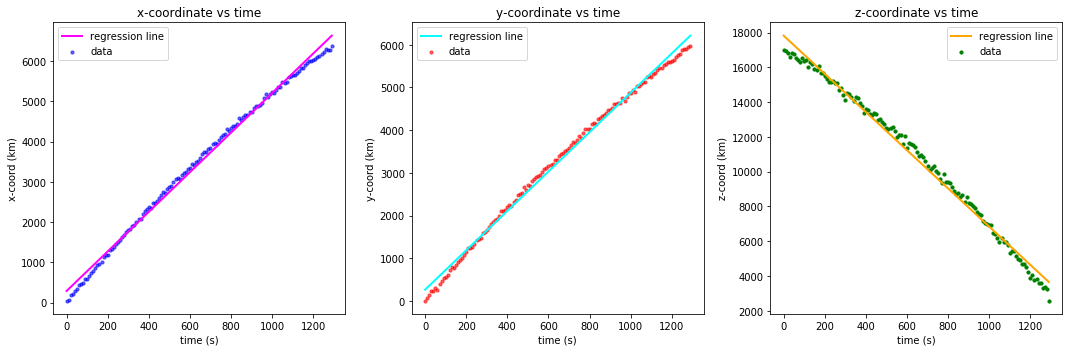

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

#fit a linear model for x vs t
line = Linear()
line.fit(data[:, 0].reshape((data.shape[0], 1)), data[:, 1])
x_pred = line.predict(data[:, 0].reshape((data.shape[0], 1)))

#plot x vs t
ax1.scatter(data[:, 0], data[:, 1], 
            color='blue', 
            s=10,
            alpha=0.6,
            label='data')

#plot linear model for x vs t
ax1.plot(data[:, 0], x_pred, 
         color='magenta',
         linewidth=2,
         label='regression line')

ax1.set_xlabel('time (s)')
ax1.set_ylabel('x-coord (km)')
ax1.set_title('x-coordinate vs time')
ax1.legend(loc='best')

#fit a linear model for y vs t
line = Linear()
line.fit(data[:, 0].reshape((data.shape[0], 1)), data[:, 2])
y_pred = line.predict(data[:, 0].reshape((data.shape[0], 1)))

#plot y vs t
ax2.scatter(data[:, 0], data[:, 2], 
            color='red', 
            s=10,
            alpha=0.6,
            label='data')

#plot linear model for y vs t
ax2.plot(data[:, 0], y_pred, 
         color='cyan',
         linewidth=2,
         label='regression line')

ax2.set_xlabel('time (s)')
ax2.set_ylabel('y-coord (km)')
ax2.set_title('y-coordinate vs time')
ax2.legend(loc='best')

#fit a linear model for z vs t
line = Linear()
line.fit(data[:, 0].reshape((data.shape[0], 1)), data[:, 3])
z_pred = line.predict(data[:, 0].reshape((data.shape[0], 1)))

#plot z vs t
ax3.scatter(data[:, 0], data[:, 3], 
            color='green', 
            s=10,
            label='data')

#plot linear model for y vs t
ax3.plot(data[:, 0], z_pred, 
         color='orange',
         linewidth=2,
         label='regression line')

ax3.set_xlabel('time (s)')
ax3.set_ylabel('z-coord (km)')
ax3.set_title('z-coordinate vs time')
ax3.legend(loc='best')

plt.tight_layout()
plt.show()

All three coordinates look like they have **non-linear** relationships with time, as evident by the way the scatter plots above curves away from their respective best fitting lines. 

**As a side note:** some of you modeled $x$ and $y$ as a function of $z$, e.g. $x = f(z), y=g(z)$. This is not a good idea. For one, from common sense, we know that the position of a falling object is a function of time (where the object is depends on how long it's been falling). In the case of zero noise, we can sometimes solve for one coordinate in terms of another - this is mathematically valid. However, recall that, when performing linear regression, we assume a number of things about our data: 
$$
\text{response} = f(\text{predictors}) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)
$$
Now, we also implicitly assume that the predictors are noiseless. In our case, we have already disclosed that the radar readings are noisy, which means that the variables $x, y, z$ are all noise containminated. The only variable that one can reasonably assume to be noiseless is time, $t$. So what happens if **$z$ and $x$ are noisy non-linear functions of $t$** and you learn a model $x = f(z)$?

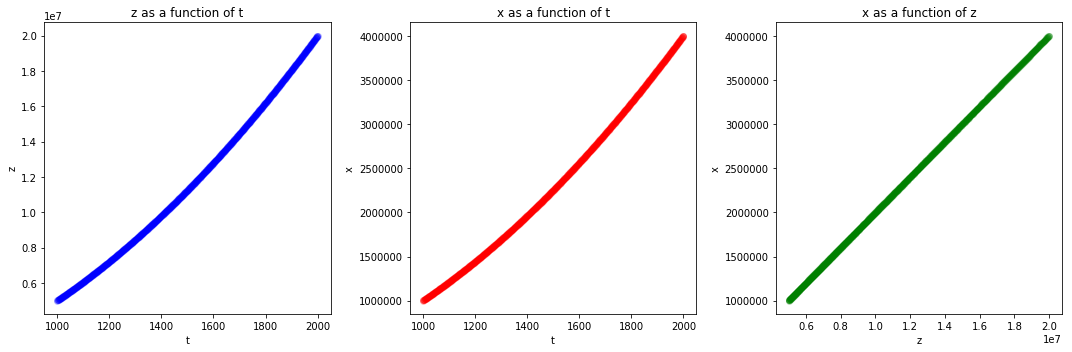

In [28]:
#Number of points to generate
n = 1000
#Generate some time values
t = np.linspace(1000, 2000, n)
#Generate noise for z
e_z = np.random.normal(0, 1, n)
#Generate noise for x
e_x = np.random.normal(0, 1, n)

#Noisy model of z as a quadratic function of time
z = 5 * t**2 + t + 1 + e_z
#Noisy model of y as a quadratic function of time
x = t**2 + t + 1 + e_x

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

#Plot z as a function of t
ax1.scatter(t, z, color='blue', alpha=0.2)
ax1.set_xlabel('t')
ax1.set_ylabel('z')
ax1.set_title('z as a function of t')

#Plot x as a function of t
ax2.scatter(t, x, color='red', alpha=0.2)
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_title('x as a function of t')

#Plot x as a function of z
ax3.scatter(z, x, color='green', alpha=0.2)
ax3.set_xlabel('z')
ax3.set_ylabel('x')
ax3.set_title('x as a function of z')

plt.tight_layout()
plt.show()

When we plot $z$ vs $x$, the scatter plot suggests a linear relationship. So would a linear model be appropriate? Let's fit a linear model and plot the residuals (just as we do in Homework #2).

R^2 value: 0.999999999482


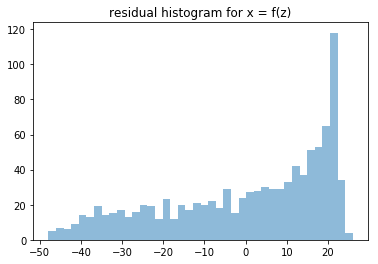

In [29]:
#Fit linear model for z as a function of x
line = Linear(fit_intercept=True)
line.fit(z.reshape((z.shape[0], 1)), x)
x_pred = line.predict(z.reshape((z.shape[0], 1)))

#R^2 of fit
print('R^2 value:', line.score(z.reshape((z.shape[0], 1)), x))

#Residuals
res = x - x_pred

#Plot residual histogram
plt.hist(res, bins=40, alpha=0.5)
plt.title('residual histogram for x = f(z)')
plt.show()

We know from Homework #2 that linear regression is appropriate when the histogram of the residual is normal (indicating that noise is normal). Even though our R^2 is good, we can see from the residual histogram that, in our model $x_i = f(z_i) + \epsilon_i$, the noise term is probably not iid normally distributed. So what's wrong with using regression results with good R^2 when the regression model assumptions are not satisfied? Well, the **forcasts** we make with such models may be at best simply inefficient, or, at worst, seriously wrong and misleading (recall from class the four Anscombe datasets with identically high R^2 values)! 

If you're still tempted by the high R^2 value of our linear model $x = f(z)$, consider this: let's say that after we've learned a model for $x = f(z)$, we now want to predict the value of $x$ when $z = 0$ (as a number of you have done in your midterm solutions). With our model $x = f(z)$, all we have to do is plug in $z=0$. But is our prediction any good?

x-value when z=0 predicted by our model 583.213503936


[]

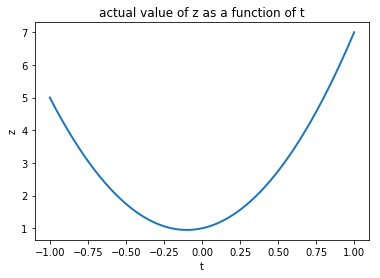

In [30]:
#Predict x when z=0 using our model
z_0 = np.zeros((1, 1))
print('x-value when z=0 predicted by our model', line.predict(z_0)[0])

#When is z=0 again?
t = np.linspace(-1, 1, 400)

plt.plot(t, 5 * t**2 + t + 1, linewidth=2)

plt.title('actual value of z as a function of t')
plt.xlabel('t')
plt.ylabel('z')
plt.plot()

Our model $x = f(z)$, with it's incredibly high R^2 value, has beguiled us into thinking that $x \approx 582.903146$ when $z=0$. But if we visualize $z$ as a function of $t$, we realize that the very question we ask in the prediction makes no sense: **$z$ is never equal to zero**. 

**Conclusion:** If we know that $z$ and $x$ are noisy non-linear functions of $t$, it's not a good idea to model $x$ as a function of $z$! The pathologies described above are less extreme on our data but it is nontheless present! In this application, where the lives of hypothetical people are hanging on the outcome of our decision, we need to build models that are as sensible as possible.

### Step 3: Predict the impact point

Each radar reading contains time (in seconds), the x, y-coordinate (in kilometers with respect to some fixed point on the surface of the Earth), and the z-coordinate (in kilometers) representing the altitude of the meteoroid. Clearly, at the time of impact, altitude (z-coordinate) must be equal to zero. Thus, we are trying to solve for $t_{impact}$ such that $z(t_{impact}) = 0$. This will require us to model the z-coordinate as a function of time, i.e. learn a function $z = f(t)$. 

Now, after having learned the time of impact, we can predict the x, y-coordinates of the impact point, if we can model the x, y-coordinates as a function of time. Just to keep things simple, let's assume that x and y can be modeled **separately** as functions of time:
$$
x = h(t), \quad y = g(t).
$$

**Model selection:** From our data visualization, we suspect that the functions $f, h, g$ are non-linear. Again, to keep things simple, we'll try to approximate the functions $f, h, g$ with polynomial functions. We already know how to fit polynomial models to a data set; then, the only thing we need to determine is the degree(s) of the polynomial(s) appropriate for our functions. We will determine the best degree for each function using the BIC (you may wish to use MSE, $R^2$ or AIC instead, or you might even use LASSO to automatically select the significant polynomial terms; in practice, since all of these model selection methods are **heuristic**, it may be wise to use more than one criteria to perform model selection and then compare the models selected by each criterion). 

**Regularization:** We will perform Ridge regression on the expanded set of predictors ($t$, $t^2$, $\ldots$, $t^d$) to prevent overfitting. The optimal parameter $\lambda$ for Ridge will  be determined through 5-fold cross-validation using CV MSE (again, you may choose a different **heuristic** for parameter tuning, for example, bootstrap using R^2).

The code we use are mostly from Homework #3 and #4. We'll use `RidgeCV` from `sklearn` rather than `Ridge`, as `RidgeCV` automatically performs parameter tuning (for the regularization parameter $\lambda$) using k-fold x-validation.

In [31]:
def ridge_cv(x, y, lambdas):
    model = []
    cv_R_sq = []
    for l in lambdas:
        R_sq = []        
        
        for i in range(100):
            train = np.random.choice(range(50, len(x)))
            x_train = x[:train]
            y_train = y[:train]
        
            x_test = x[train:]
            y_test = y[train:]
            
            ridge = Ridge(alpha=l, fit_intercept=False, normalize=True)
            ridge.fit(x_train, y_train)
            
            R_sq.append(ridge.score(x_test, y_test))
            
        cv_R_sq.append(np.mean(R_sq))
        model.append(ridge)
            
    ind = np.argmax(cv_R_sq)
    return model[ind], lambdas[ind]
            


#Function for calculating BIC
BIC = lambda n, d, RSS: n * np.log(RSS * 1. / n) + d * np.log(n)
#Function for calculating Residual Sum of Squares
RSS = lambda predict, actual: np.sum((predict - actual)**2)

#Function for finding the best polynomial model using Ridge polynomial regression
def best_poly_model(pred, response, max_deg, reg_params):
    #Best regularization parameter for each degree
    lambdas = []
    #Best BIC for each degree
    bics = []
    #Best model parameters for each degree
    params = []
    
    #Iterate through degrees 1 to max_degree
    for degree in range(1, max_deg):
        #Print progress
        sys.stdout.write("\r{0}% completed".format((float(degree)/(max_deg - 1))*100))
        sys.stdout.flush()
        
        #Turn one predictor into 1, t, t^2, t^3, ...
        poly_t = PolynomialFeatures(degree=degree)
        pred_expanded = poly_t.fit_transform(pred)
        
        #Perform Ridge regression using expanded set of predictors, 
        #choose best regularization parameter lambda using 5-fold x-validation
        ridge, l = ridge_cv(pred_expanded, response, reg_params)
        ridge.fit(pred_expanded, response)
        
        #Record the parameters of the model chosen by 5-fold x-validation
        params.append(ridge.coef_)
        #Record the lambda chosen by 5-fold x-validation
        #lambdas.append(ridge.alpha_)
        lambdas.append(l)
        
        #Record the BIC score of the model chosen by 5-fold x-validation
        response_hat = ridge.predict(pred_expanded) 
        
        
        error = RSS(response_hat, response)
        bics.append(BIC(pred.shape[0], degree, error))
    
    #Find the degree with the min BIC score
    best_degree = np.argmin(bics) + 1
    #Find the best lambda for the degree with the min BIC score
    best_lambda = lambdas[best_degree - 1]
    #Find the best model parameters for the degree with the min BIC score
    best_params = params[best_degree - 1]
    
    return best_degree, best_lambda, best_params       

In [32]:
#Set maximum polynomial degree
max_degree = 10

#Create our dataset
t = data[:, 0]
x = data[:, 1]
y = data[:, 2]
z = data[:, 3]

#List of regularization parameters to try
lambdas = np.hstack((10.**np.array([-3, -2, -1, 0, 1, 2, 3]), np.array([0]) ))

In [33]:
#Lear a model for z = f(t)
best_degree_z, best_lambda_z, z_best_params  = best_poly_model(t.reshape((t.shape[0], 1)), z, max_degree, lambdas)    
    
print('best polynomial model for z = f(t) has degree:', best_degree_z)
print('best regularization parameter for this degree:', best_lambda_z)
print('best intercept for this degree (ridge regression):', z_best_params[0])
print('best coefficients for this degree (ridge regression):', z_best_params[1:])

100.0% completed9% completedbest polynomial model for z = f(t) has degree: 2
best regularization parameter for this degree: 0.01
best intercept for this degree (ridge regression): 17046.2747009
best coefficients for this degree (ridge regression): [ -7.36474816e+00  -2.80170653e-03]


In [34]:
#Lear a model for x = h(t)
best_degree_x, best_lambda_x, x_best_params  = best_poly_model(t.reshape((t.shape[0], 1)), x, max_degree, lambdas)    
    
print('best polynomial model for x = h(t) has degree:', best_degree_x)
print('best regularization parameter for this degree:', best_lambda_x)
print('best intercept for this degree (ridge regression):', x_best_params[0])
print('best coefficients for this degree (ridge regression):', x_best_params[1:])

100.0% completed9% completedbest polynomial model for x = h(t) has degree: 3
best regularization parameter for this degree: 10.0
best intercept for this degree (ridge regression): 10.709553153
best coefficients for this degree (ridge regression): [  6.24713608e+00  -1.12306247e-03   8.47021927e-08]


In [35]:
#Lear a model for y = g(t)
best_degree_y, best_lambda_y, y_best_params  = best_poly_model(t.reshape((t.shape[0], 1)), y, max_degree, lambdas)    
    
print('best polynomial model for y = g(t) has degree:', best_degree_y)
print('best regularization parameter for this degree:', best_lambda_y)
print('best intercept for this degree (ridge regression):', y_best_params[0])
print('best coefficients for this degree (ridge regression):', y_best_params[1:])

100.0% completed9% completedbest polynomial model for y = g(t) has degree: 3
best regularization parameter for this degree: 100.0
best intercept for this degree (ridge regression): -0.00790387307661
best coefficients for this degree (ridge regression): [  5.92054410e+00  -1.18089837e-03   1.43423461e-07]


Now that we have the functional forms for $x, y$ and $z$, let's set $z = f(t) = 0$ and solve for $t$. You can either do this by predicting $z$-values for a range of $t$'s until $z$ is close to zero. Or you can find the roots of the polynomial $z = f(t)$.

We will find the roots of the polynomial $f(t)$ using `numpy.roots()`.

In [37]:
#Find the roots of the polynomial f(t)
roots = np.roots(z_best_params[::-1])
print(roots)

[-4109.27746567  1480.61237171]


Clearly, we don't want a negative number for $t$. So the impact time must be the positive root of $f(t)$.

In [38]:
#Take a positive root to be the impact time
t_impact = roots[roots > 0][0]
print(t_impact)

1480.61237171


Now that we have the impact time $t_{impact}$, we can plug $t_{impact}$ into the functions $x = h(t)$ and $y = g(t)$ to predict the $x, y$-coordinates of impact.

In [39]:
#Predict x-coord of impact

#Turn t into 1, t, t^2, t^3,...
t_impact = np.array([t_impact]).reshape((1, 1))
poly_t = PolynomialFeatures(degree=best_degree_x)
t_expanded = poly_t.fit_transform(t_impact)

#Multiply t-vals with coefficients for the model x = h(t)
x_coord = t_expanded.dot(x_best_params)[0]

print('predicted x-coord of impact', np.round(x_coord, 2), 'km')

predicted x-coord of impact 7073.23 km


In [40]:
#Predict y-coord of impact

#Turn t into 1, t, t^2, t^3,...
poly_t = PolynomialFeatures(degree=best_degree_y)
t_expanded = poly_t.fit_transform(t_impact)

#Multiply t-vals with coefficients for the model y = g(t)
y_coord = t_expanded.dot(y_best_params)[0]

print('predicted y-coord of impact', np.round(y_coord, 2), 'km')

predicted y-coord of impact 6642.77 km


---

## Computing the 90% Predictive Interval for Impact Point

We will compute the predictive interval through bootstrapping. That is, we simulate resampling the data ($x$, $y$ and $z$) a bunch of times and keep track of the predicted impact points we get for each simulation. From these predictions, we compute the mean prediction as well as the  90% range of our predicted values for $x$ and $y$. 

We already have the code for predicting the impact $x$, $y$-coordinates, we just need to wrap it up in a function so that we can call it a bunch of times during our simulation.

In [41]:
#Function to fit a polynomial model with Ridge regression
def fit_poly(pred, response, degree, reg_param):
    #Turn one predictor into 1, t, t^2, t^3, ...
    poly_t = PolynomialFeatures(degree=degree)
    pred_expanded = poly_t.fit_transform(pred)

    #Perform Ridge regression using expanded set of predictors
    ridge = Ridge(alpha=reg_param, fit_intercept=False, normalize=True)
    ridge.fit(pred_expanded, response)
        
    return ridge.coef_

#Function to compute impact point
def simulate_impact(t, x, y, z):
    #Lear a model for z = f(t)
    z_best_params  = fit_poly(t, z, best_degree_z, best_lambda_z)    
    
    #Lear a model for x = h(t)
    x_best_params  = fit_poly(t, x, best_degree_x, best_lambda_x)      

    #Lear a model for y = g(t)
    y_best_params  = fit_poly(t, y, best_degree_y, best_lambda_y)      

    ###Find impact time
    
    #Find the roots of the polynomial f(t)
    roots = np.roots(z_best_params[::-1])
    
    #Take a positive root to be the impact time
    t_impact = roots[roots > 0][0]
    
    ###Predict x-coord of impact

    #Turn t into 1, t, t^2, t^3,...
    t_impact = np.array([t_impact]).reshape((1, 1))
    poly_t = PolynomialFeatures(degree=best_degree_x)
    t_expanded = poly_t.fit_transform(t_impact)

    #Multiply t-vals with coefficients for the model x = h(t)
    x_coord = t_expanded.dot(x_best_params)[0]
    
    ###Predict y-coord of impact

    #Turn t into 1, t, t^2, t^3,...
    poly_t = PolynomialFeatures(degree=best_degree_y)
    t_expanded = poly_t.fit_transform(t_impact)

    #Multiply t-vals with coefficients for the model y = g(t)
    y_coord = t_expanded.dot(y_best_params)[0]
    
    return x_coord, y_coord

In [42]:
num_simulations = 2500
subsample_size = 130
x_coords = []
y_coords = []

#Simulate re-sampling the data and computing the impact coordinates a bunch of times
for i in range(num_simulations):
    #Print progress
    sys.stdout.write("\r{0}% completed".format((float(i + 1)/num_simulations)*100))
    sys.stdout.flush()
    
    #Sample from the data
    index_set = np.random.choice(range(len(data)), size=subsample_size, replace=True) 
    
    #Create our subsample
    t = data[index_set, 0]
    x = data[index_set, 1]
    y = data[index_set, 2]
    z = data[index_set, 3]
    
    #Predict impact coordinates
    x_coord, y_coord = simulate_impact(t.reshape((t.shape[0], 1)), x, y, z)
    x_coords.append(x_coord)
    y_coords.append(y_coord)
    
#Mean x-coord and 90% predictive interval    
mean_x_coord = np.mean(x_coords)
x_lower = np.percentile(x_coords, 5)
x_upper = np.percentile(x_coords, 95)

#Mean y-coord and 90% predictive interval 
mean_y_coord = np.mean(y_coords)
y_lower = np.percentile(y_coords, 5)
y_upper = np.percentile(y_coords, 95)

print('\nmean x-coord', np.round(mean_x_coord, 2), 'km')
print('predictive interval (', np.round(x_lower, 2), 'km,', np.round(x_upper, 2), 'km )')

print('mean y-coord', np.round(mean_y_coord, 2), 'km')
print('predictive interval (', np.round(y_lower, 2), 'km,', np.round(y_upper, 2), 'km )')

100.0% completed1% completeddd
mean x-coord 7075.1 km
predictive interval ( 7031.76 km, 7124.03 km )
mean y-coord 6642.85 km
predictive interval ( 6599.98 km, 6687.85 km )


Just as a sanity check, let's plot the histogram (along with the mean and predictive interval) of our predicted coordinates. If we're bootstrapping correctly, we should see the distribution of x-coord and y-coord looking close to normal.

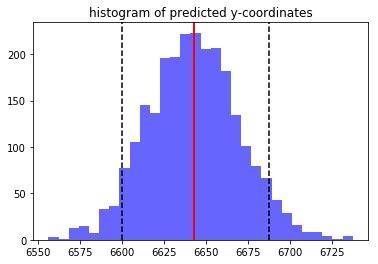

In [43]:
#Plot histogram of y-coords
plt.hist(y_coords, bins=30, color='blue', alpha=0.6)
#Plot mean of y-coords
plt.axvline(x=mean_y_coord, color='red', linewidth=2)
#Plot lower bound of predictive interval for y-coords
plt.axvline(x=y_lower, color='black', linestyle='--')
#Plot upper bound of predictive interval for y-coords
plt.axvline(x=y_upper, color='black', linestyle='--')

plt.title('histogram of predicted y-coordinates')
plt.show()

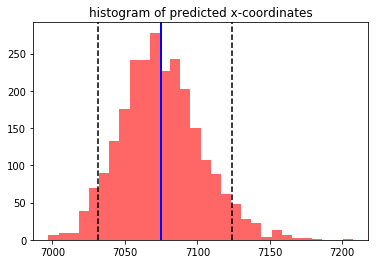

In [44]:
#Plot histogram of x-coords
plt.hist(x_coords, bins=30, color='red', alpha=0.6)
#Plot mean of x-coords
plt.axvline(x=mean_x_coord, color='blue', linewidth=2)
#Plot lower bound of predictive interval for x-coords
plt.axvline(x=x_lower, color='black', linestyle='--')
#Plot upper bound of predictive interval for x-coords
plt.axvline(x=x_upper, color='black', linestyle='--')
plt.title('histogram of predicted x-coordinates')
plt.show()

Note that the **90% predictive region** may not be a box, `[x_lower x x_upper] x [y_lower x y_upper]`, if $x$ and $y$ predictions are correlated! Just to keep things simple and to err on the side of over-estimating potential casualties, let's use the box `[x_lower x x_upper] x [y_lower x y_upper]` to represent our 90% predictive region.

In case you do want to be more precise about your 90% predictive region, you can note that the distribution of the $x$ and $y$ impact coordinate estimates are approximately normal. Thus, their joint distribution will also be normal (a great fact about normal distributions)! Now, if we want to find the 90% interval of their joint distribution (a bivariate normal distribution), we just need to find the covariance matrix of $x$ and $y$. 

---

## Predicting Number of People Affected by Impact

### Step 1: Read the data for the town and do some preliminary explorations

In [45]:
df = pd.read_csv('data/midtermbuildings.csv')
df.head(n=20)

,residents,bed,bath,x,y
0,3.0,4,3,7201.60,6752.56
1,2.0,2,1,7079.68,6622.32
2,4.0,2,1,7154.40,6683.28
3,2.0,1,2,7093.44,6680.56
4,1.0,2,2,7198.72,6674.96
5,0.0,2,1,7101.76,6655.60
6,3.0,2,1,7157.28,6652.72
7,NaN,3,5,7088.00,6749.84
8,3.0,2,1,7160.00,6525.36
9,1.0,1,1,7201.60,6627.76


It looks like the dataset contains information for each dwelling in the town - the number of residents in the building, the number of bed and bath and the location of the dwelling. We notice right away that there are some values in the `residents` column that are missing!

### Step 2: Fix problems with the data

Before we can use this dataset, we have to fill in the missing data. We'll use KNN to fill in the missing data. To find the best $k$, we can take the rows with no missing values and create some test datasets by deleting values for some of the buildings.

For this task, we'll use code from Homework #1.

In [46]:
#Function to fill in missing data using KNN
def KNN_fill(df_missing, df_filled, k):
    knn = KNN(n_neighbors=k)
    knn.fit(df_filled.loc[:, 'bed':], df_filled['residents'])
    df_predict = df_missing.copy()
    df_predict.loc[:, 'residents'] = knn.predict(df_missing.loc[:, 'bed':])
    return df_predict
        
#Separate the rows with missing residents information
df_missing = df[df['residents'].isnull()]
df_filled = df[~df['residents'].isnull()]
test_ind = int(0.3 * len(df_filled.index))

###Find an appropriate k for KNN
best_ks = []

#Create 100 simulated test and train set from df_filled
for i in range(100):  
    #Print progress
    sys.stdout.write("\r{0}% completed".format((float(i + 1)/100)*100))
    sys.stdout.flush()
    
    RSS = []
    
    #For each simulated test and train set, try k-values: 1 to 15 (counting by 2)
    for k in range(1, 15, 2):
        df_shuffled = df_filled.sample(frac=1)
        df_test = df_shuffled.iloc[:test_ind, :]
        df_train = df_shuffled.iloc[test_ind:, :]
    
        #Fill rows with missing residents information
        df_pred = KNN_fill(df_test, df_train, k)
        
        #Compute RSS of filled in data
        RSS.append(((df_pred['residents'] - df_test['residents'])**2).mean())
    
    #Record the k that yields the smallest RSS
    best_ks.append(np.argmin(RSS) + 1)

#Take the mean of the best k over 100 simulations
best_k = int(np.mean(best_ks))
print('\nthe best k is', best_k)

#Fill rows with missing residents information, using the optimal k
df_missing = KNN_fill(df_missing, df_filled, best_k)

#Concatenate rows with no missing info and the row we filled in
df_final = pd.concat([df_filled, df_missing])
df_final = df_final.sort_index()
df_final.head(n=20)

100.0% completed9% completedd
the best k is 5


,residents,bed,bath,x,y
0,3.0,4,3,7201.60,6752.56
1,2.0,2,1,7079.68,6622.32
2,4.0,2,1,7154.40,6683.28
3,2.0,1,2,7093.44,6680.56
4,1.0,2,2,7198.72,6674.96
5,0.0,2,1,7101.76,6655.60
6,3.0,2,1,7157.28,6652.72
7,2.2,3,5,7088.00,6749.84
8,3.0,2,1,7160.00,6525.36
9,1.0,1,1,7201.60,6627.76


### Step 3: Predicting the number of people affected by impact

Now, we just need to figure out which of the buildings fall into our 90% predictive region for impact, and tally the number of residents affected. Since our predictive region is the box `[x_lower x x_upper] x [y_lower x y_upper]`, clearly, a building is affected if its $x$-coordinate fall into our 90% predictive interval for $x$ **and** its  $y$-coordinate fall into our 90% predictive interval for $y$.

In [47]:
#Find the buildings that fall into our predictive interval
df_affected = df_final[(df_final['x'] >= x_lower) & (df_final['x'] <= x_upper) 
                       & (df_final['y'] >= y_lower) & (df_final['y'] <= y_upper)]

#Find total number of ppl affected
total_ppl = df_affected['residents'].sum()

print('The total number of ppl affected:', total_ppl)

The total number of ppl affected: 758.2


Just for a sanity check, let's plot the dwellings in our town as scatter plot, the color and size of whose points encode the number of residents.

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


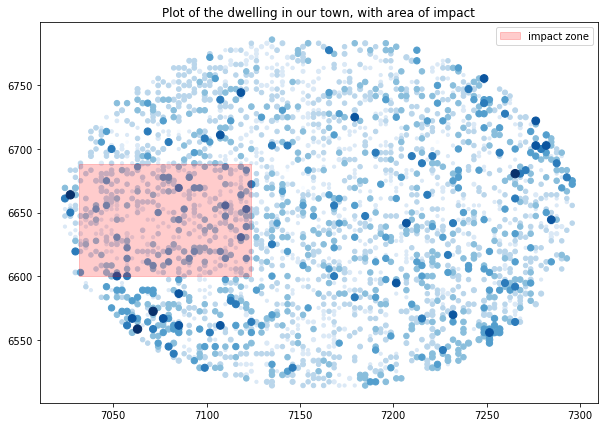

In [48]:
#Sort dataframe by number of residents 
#(so that the more densely populated dwellings are plotted last)
df_final.sort_values(by='residents', inplace=True)

#split [0, 1] in to as many parts as there are values for residents
vals = np.linspace(0, 1, np.max(df_final['residents'].values) + 1)
#get a color map
c_map = plt.get_cmap('Blues') 
#get a range of colors from color map
c_norm  = colors.Normalize(vmin=0, vmax=1)
#get a map that maps a particular number of residents to a color
number_map = cmx.ScalarMappable(norm=c_norm, cmap=c_map)

#get a color for each dwelling point depending on the number of residents
scatter_colors = [number_map.to_rgba(vals[int(residents)]) 
                  for residents in df_final['residents'].values]

#get a size for each dwelling point depending on the number of residents
sizes = df_final['residents'].values * 10

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
#plot the dwellings
ax.scatter(df_final['x'].values, df_final['y'].values, 
           color=scatter_colors, 
           s=sizes)

#plot a rectangle representing the impact zone
ax.add_patch(patches.Rectangle((x_lower, y_lower), 
                               x_upper - x_lower, y_upper - y_lower, 
                               color='red', 
                               alpha=0.2, 
                               label='impact zone'))

ax.set_title('Plot of the dwelling in our town, with area of impact')
ax.legend(loc='best')
plt.show()

---

## Challenge Question: Incorporate a second set of radar readings

### Step 1: Read the data and do some preliminary explorations

In [50]:
data_2 = np.loadtxt('data/midterm_a_r2_d1.csv', )
print('shape', data_2.shape)

data_2[:, 0] = data_2[:, 0]
print(data_2[:5, :])

shape (120, 4)
[[  0.00000000e+00   5.79491062e+00  -4.63427498e+00   1.69487327e+04]
 [  1.00000000e+01   5.83237671e+01   4.17830071e+01   1.69051155e+04]
 [  2.00000000e+01   1.28223593e+02   1.17248328e+02   1.68715907e+04]
 [  3.00000000e+01   1.92545884e+02   1.83249677e+02   1.67764636e+04]
 [  4.00000000e+01   2.52344325e+02   2.29015468e+02   1.66903752e+04]]


It looks like that the second set of radar measurements has less data than the first. So rather than ditching the first set of radar measurements all together, we will combine the two sets of readings (noisy measurements are better than no measurements at all). But, at the same time, we want to  take into account the accuracy of each reading.

### Step 2: Weight the two data sets and combine

Let's weight each reading based on its accuracy. That is, we will give the accurate readings from radar #2 a higher numerical score and less accurate readings from radar #1 a lower numerical score. 

**What is an optimal weight to assign to a noisy (and, respectively, accurate) reading**? If you have information about the noisy level of each data set (like if the noise is iid normal with variance $\sigma^2$), you can use the (inverse of the) variance of noise to weight your data. On the other hand, we can empirically learn a "good" noise weight. That is, we can create a bunch of train and test sets from our data and try out different weights. For each train, test set pair we make, we'll fit a weighted polynomial regression model on the train and compute the R^2 on the test; we will select a noise weight that yields the maximum R^2 in our trials. 

Now, you might notice that for each weight, we still need to decide on the polynomial degree and the regularization parameter. Since trying to tune three parameters simultaneously is costly, for each weight, we will simply fit a polynomial of the degree we found to be optimal for the first set of radar readings; we will also use the optimal regularization we fround from before. Again, this is a **heuristic approach** that saves time. You may very well choose to tune weight, polynomial degree and regularization parameter simulataneously. 

Recall from Challenge Problem, Homework #3, that performing weighted regression is equivalent to weighting the data, combining them and then performing regular regression. In this problem, we will perform weighted regression by turning on the `sample_weight` parameter in `sklearn`'s Ridge regression `.fit()` function. The parameter `sample_weight` allows us to pass in a list of weights, one for each data point, while fitting our Ridge regression.

In [51]:
#Function to fit a polynomial model with Ridge regression
def fit_poly_weighted(pred_train, response_train,  
                      degree, reg_param, weights, 
                      pred_test=None, response_test=None):
    score = 0
    
    #Turn one predictor into 1, t, t^2, t^3, ...
    poly_t = PolynomialFeatures(degree=degree)
    pred_train_expanded = poly_t.fit_transform(pred_train)
    
    if pred_test is not None:
        pred_test_expanded = poly_t.fit_transform(pred_test)

    #Perform weighted Ridge regression using expanded set of predictors
    ridge = Ridge(alpha=reg_param, fit_intercept=False, normalize=True)
    #Notice that when we fit our model we pass in a set of weights!
    ridge.fit(pred_train_expanded, response_train, sample_weight=weights)
    
    if pred_test is not None and response_test is not None:
        score = ridge.score(pred_test_expanded, response_test)
        
    return ridge.coef_, score

Learning the optimal noise weight:

In [53]:
#The range of noise weights we want to test
noisy_weight = np.linspace(0.01, 0.49, 10)

#The number of train, test sets we want to create
num_simulations = 100

#The percentage of train we want from each radar dataset
split_1 = int(130 * 0.7)
split_2 = int(120 * 0.7)

#The mean R^2 for the fit on t vs x, t vs y and t vx z for each noise weight
mean_r_sq = []

#j is just a counter to help us compute the progress
j = -1

#Try every noise weight in our range of noise weights
for weight in noisy_weight:   
    j += 1
    
    #Keep track of the R^2 for each train, test set we create
    r_sq = []
    
    #Create a bunch of train, test sets
    for i in range(num_simulations):
        #Print progress
        sys.stdout.write("\r{0}% completed".format((((i + 1.) + j * num_simulations) / 
                                                    (num_simulations * len(noisy_weight)))*100))
        sys.stdout.flush()

        #Create random train and testing set from data
        np.random.shuffle(data) 
        np.random.shuffle(data_2) 
        
        data_train = np.vstack((data[:split_1, :], data_2[:split_2, :]))
        data_test = np.vstack((data[split_1:, :], data_2[split_2:, :]))
        
        #Create weights for each radar reading
        weights = [weight] * split_1 + [1 - weight] * split_2
        
        #Create our train set
        t_train = data_train[:, 0].reshape((data_train.shape[0], 1))
        x_train = data_train[:, 1]
        y_train = data_train[:, 2]
        z_train = data_train[:, 3]
        
        #Create our test set
        t_test = data_test[:, 0].reshape((data_test.shape[0], 1))
        x_test = data_test[:, 1]
        y_test = data_test[:, 2]
        z_test = data_test[:, 3]
        
        #Lear a model for z = f(t) and compute R^2 on test
        _, z_r_sq  = fit_poly_weighted(t_train, z_train,
                                       best_degree_z, best_lambda_z,
                                       weights,
                                       pred_test=t_test, response_test=z_test)    
    
        #Lear a model for x = h(t) and compute R^2 on test
        _, x_r_sq  = fit_poly_weighted(t_train, x_train,
                                       best_degree_x, best_lambda_x,
                                       weights,
                                       pred_test=t_test, response_test=x_test)      

        #Lear a model for y = g(t) and compute R^2 on test
        _, y_r_sq  = fit_poly_weighted(t_train, y_train,  
                                       best_degree_y, best_lambda_y,
                                       weight,
                                       pred_test=t_test, response_test=y_test)  
        
        #Record the average R^2 from all three of the models above
        r_sq.append(np.mean([z_r_sq, x_r_sq, y_r_sq]))
    
    #Record the average R^2 over all the test sets we made
    mean_r_sq.append(np.mean(r_sq))

#Find the noise weight corresponding to the max R^2
best_weight = noisy_weight[np.argmax(mean_r_sq)]

print('\nbest noise weight:', best_weight)

100.0% completed9% completedd
best noise weight: 0.17


### Step 3: Perform weighted regression and predict

After weighting and combining our two sets of radar reading, we can repeat model fitting and impact prediction process, just as in the above.

In [54]:
#Function to compute impact point
def simulate_impact(t, x, y, z, weights):
    #Lear a model for z = f(t)
    z_best_params, _  = fit_poly_weighted(t, z,
                                          best_degree_z, best_lambda_z, 
                                          weights)  

    #Lear a model for x = h(t)
    x_best_params, _  = fit_poly_weighted(t, x, 
                                          best_degree_x, best_lambda_x, 
                                          weights)      

    #Lear a model for y = g(t)
    y_best_params, _  = fit_poly_weighted(t, y, 
                                          best_degree_y, best_lambda_y, 
                                          weights)      

    ###Find impact time
    
    #Find the roots of the polynomial f(t)
    roots = np.roots(z_best_params[::-1])
    
    #Take a positive root to be the impact time
    t_impact = roots[roots > 0][0]
    
    ###Predict x-coord of impact

    #Turn t into 1, t, t^2, t^3,...
    t_impact = np.array([t_impact]).reshape((1, 1))
    poly_t = PolynomialFeatures(degree=best_degree_x)
    t_expanded = poly_t.fit_transform(t_impact)

    #Multiply t-vals with coefficients for the model x = h(t)
    x_coord = t_expanded.dot(x_best_params)[0]
    
    ###Predict y-coord of impact

    #Turn t into 1, t, t^2, t^3,...
    poly_t = PolynomialFeatures(degree=best_degree_y)
    t_expanded = poly_t.fit_transform(t_impact)

    #Multiply t-vals with coefficients for the model y = g(t)
    y_coord = t_expanded.dot(y_best_params)[0]
    
    return x_coord, y_coord

In [59]:
num_simulations = 1000
subsample_1_size = 130
subsample_2_size = 120

x_coords = []
y_coords = []

#Simulate re-sampling the data and computing the impact coordinates a bunch of times
for i in range(num_simulations):
    #Print progress
    sys.stdout.write("\r{0}% completed".format((float(i + 1)/num_simulations)*100))
    sys.stdout.flush()
    
    #Sample from the data
    index_set_1 = np.random.choice(range(len(data)), size=subsample_1_size, replace=True) 
    index_set_2 = np.random.choice(range(len(data_2)), size=subsample_2_size, replace=True) 
        
    #Create our subsample
    t = np.hstack((data[index_set_1, 0], data_2[index_set_2, 0]))
    x = np.hstack((data[index_set_1, 1], data_2[index_set_2, 1]))
    y = np.hstack((data[index_set_1, 2], data_2[index_set_2, 2]))
    z = np.hstack((data[index_set_1, 3], data_2[index_set_2, 3]))
    
    #Weight our subsample
    weights = [best_weight] * len(index_set_1) + [1 - best_weight] * len(index_set_2)
    
    #Predict impact coordinates
    x_coord, y_coord = simulate_impact(t.reshape((t.shape[0], 1)), x, y, z, weights)
    x_coords.append(x_coord)
    y_coords.append(y_coord)
    
#Mean x-coord and 90% predictive interval    
mean_x_coord = np.mean(x_coords)
x_lower_weighted = np.percentile(x_coords, 5)
x_upper_weighted = np.percentile(x_coords, 95)

#Mean y-coord and 90% predictive interval 
mean_y_coord = np.mean(y_coords)
y_lower_weighted = np.percentile(y_coords, 5)
y_upper_weighted = np.percentile(y_coords, 95)

print('\nmean x-coord', np.round(mean_x_coord, 2), 'km')
print('predictive interval (', np.round(x_lower_weighted, 2), 'km,', np.round(x_upper_weighted, 2), 'km )')

print('mean y-coord', np.round(mean_y_coord, 2), 'km')
print('predictive interval (', np.round(y_lower_weighted, 2), 'km,', np.round(y_upper_weighted, 2), 'km )')

100.0% completed9% completedd
mean x-coord 7085.11 km
predictive interval ( 7066.65 km, 7103.79 km )
mean y-coord 6644.05 km
predictive interval ( 6627.8 km, 6661.01 km )


Sanity check: visually verify that we're doing boostrap correctly.

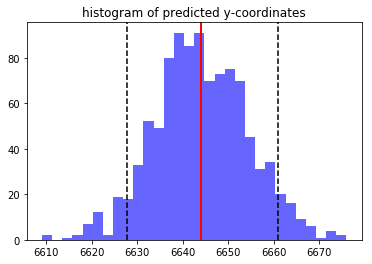

In [60]:
#Plot histogram of y-coords
plt.hist(y_coords, bins=30, color='blue', alpha=0.6)
#Plot mean of y-coords
plt.axvline(x=mean_y_coord, color='red', linewidth=2)
#Plot lower bound of predictive interval for y-coords
plt.axvline(x=y_lower_weighted, color='black', linestyle='--')
#Plot upper bound of predictive interval for y-coords
plt.axvline(x=y_upper_weighted, color='black', linestyle='--')

plt.title('histogram of predicted y-coordinates')
plt.show()

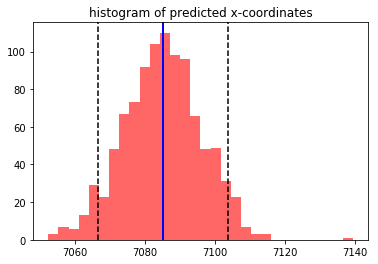

In [61]:
#Plot histogram of x-coords
plt.hist(x_coords, bins=30, color='red', alpha=0.6)
#Plot mean of x-coords
plt.axvline(x=mean_x_coord, color='blue', linewidth=2)
#Plot lower bound of predictive interval for x-coords
plt.axvline(x=x_lower_weighted, color='black', linestyle='--')
#Plot upper bound of predictive interval for x-coords
plt.axvline(x=x_upper_weighted, color='black', linestyle='--')
plt.title('histogram of predicted x-coordinates')
plt.show()

Now let's compute the number of people living in our impact region.

In [62]:
#Find the buildings that fall into our predictive interval
df_affected = df_final[(df_final['x'] >= x_lower_weighted) & (df_final['x'] <= x_upper_weighted) 
                       & (df_final['y'] >= y_lower_weighted) & (df_final['y'] <= y_upper_weighted)]

#Find total number of ppl affected
total_ppl = df_affected['residents'].sum()

print('The total number of ppl affected:', total_ppl)

The total number of ppl affected: 74.6


Let's compare the impact region we calculated with one set of radar data with the impact region we calculated with both sets.

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


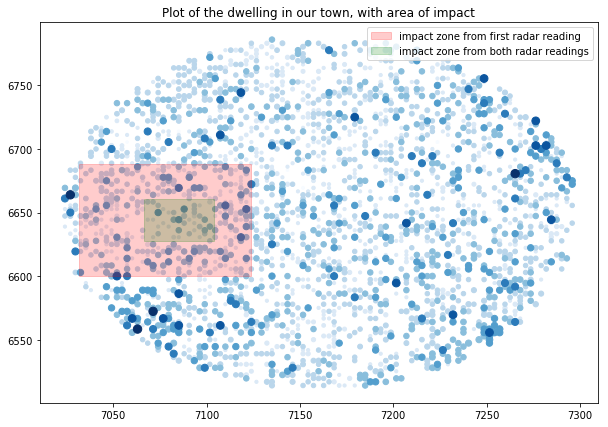

In [63]:
#Sort dataframe by number of residents 
#(so that the more densely populated dwellings are plotted last)
df_final.sort_values(by='residents', inplace=True)

#split [0, 1] in to as many parts as there are values for residents
vals = np.linspace(0, 1, np.max(df_final['residents'].values) + 1)
#get a color map
c_map = plt.get_cmap('Blues') 
#get a range of colors from color map
c_norm  = colors.Normalize(vmin=0, vmax=1)
#get a map that maps a particular number of residents to a color
number_map = cmx.ScalarMappable(norm=c_norm, cmap=c_map)

#get a color for each dwelling point depending on the number of residents
scatter_colors = [number_map.to_rgba(vals[int(residents)]) 
                  for residents in df_final['residents'].values]

#get a size for each dwelling point depending on the number of residents
sizes = df_final['residents'].values * 10

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
#plot the dwellings
ax.scatter(df_final['x'].values, df_final['y'].values, 
           color=scatter_colors, 
           s=sizes)

#plot a rectangle representing the impact zone from the first radar readings
ax.add_patch(patches.Rectangle((x_lower, y_lower), 
                               x_upper - x_lower, y_upper - y_lower, 
                               color='red', 
                               alpha=0.2, 
                               label='impact zone from first radar reading'))

#plot a rectangle representing the impact zone from both radar readings
ax.add_patch(patches.Rectangle((x_lower_weighted, y_lower_weighted), 
                               x_upper_weighted - x_lower_weighted, 
                               y_upper_weighted - y_lower_weighted, 
                               color='green', 
                               alpha=0.2, 
                               label='impact zone from both radar readings'))

ax.set_title('Plot of the dwelling in our town, with area of impact')
ax.legend(loc='best')
plt.show()

Sanity check: do the results make **common sense**? 

Apparenly, given the second set of less noisy radar readings, we are able to shrink our 90% predictive interval, further pin-pointing the most likely location of impact. This makes sense.

Our new impact region lies more or less within the impact region calculated with the first noisy radar data. This means that the added data is not altering the predicted impact point in completely surprising ways, given the weights we've assigned to the readings. This gives us some assurance that our implementations of both models are at least consistent (it is unlikely that one is buggy in a way that the other is not). 